Dense Neural Network: Implement a feedforward neural network with dense layers only. Specify the number of hidden layers, neurons
per layer, and activation functions. How will you preprocess the input images? Consider hyperparameter tuning strategies.

# Imports

Installing skorch to allow using scikit-learn with Pytorch models

In [1]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 1.6 MB/s eta 0:00:00


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [52]:
from torch.utils.data import DataLoader

In [3]:
import torch.optim as optim
import torchvision.transforms.v2 as transforms

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score

In [6]:
from skorch import NeuralNetClassifier

In [7]:
from torchvision.datasets import CIFAR10
import torchvision.datasets.utils as utils

In [62]:
import time

# Dataset Preprocessing

## Defining the transformations for the dataset

In [8]:
transformation= transforms.Compose([
    transforms.RandomAutocontrast(0.35),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Loading the dataset

In [9]:
train_data= CIFAR10(root='./data', train= True, download= True, transform= transformation)

100%|██████████| 170498071/170498071 [00:13<00:00, 12974420.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [10]:
test_data= CIFAR10(root='./data', train= False, download= True, transform= transformation)

Files already downloaded and verified


## Extracting the information to use in the GridSearch


In [11]:
y_train= np.array([y for x, y in iter(train_data)])
y_test= np.array([y for x, y in iter(test_data)])

In [12]:
x_train= np.array([x for x,y in iter(train_data)])
x_test= np.array([x for x,y in iter(test_data)])

# Model selection

## Model definition

In [37]:
class Model(nn.Module):
    def __init__(self, hidden_size, in_dims=1024,  num_classes=10):
      super(Model, self).__init__()
      self.fc1= nn.Linear(in_dims, hidden_size)
      self.fc2= nn.Linear(hidden_size, hidden_size)
      self.fc3= nn.Linear(hidden_size, num_classes)
    def forward(self,x):
      x= F.relu(self.fc1(x))
      x= F.relu(self.fc2(x))
      x= self.fc3(x)

      return x

## Creating skorch object for the model

In [43]:
model= NeuralNetClassifier(
    module= Model,
    criterion= nn.CrossEntropyLoss(),
    device= 'cuda' if torch.cuda.is_available() else 'cpu',
    optimizer= optim.Adam
)

## Defining the param grid

In [44]:
param_grid= {
    'module__hidden_size': [128, 256],
    'batch_size':[32,64],
    'max_epochs':[10,15],
    'optimizer__lr':[0.001,0.01]
}

## Running grid search

In [45]:
grid= GridSearchCV(estimator= model, param_grid=param_grid, n_jobs=-1, cv=3)

In [46]:
grid_res= grid.fit(x_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0722       0.3022        1.9493  1.7602
      2        1.9196       0.3356        1.8802  1.7050
      3        1.8582       0.3480        1.8362  1.8538
      4        1.8145       0.3520        1.8172  1.9953
      5        1.7823       0.3611        1.7989  1.6951
      6        1.7549       0.3627        1.7918  1.6945
      7        1.7337       0.3731        1.7721  1.7247
      8        1.7125       0.3815        1.7551  1.6871
      9        1.6938       0.3825        1.7498  1.7432
     10        1.6776       0.3835        1.7414  1.9910
     11        1.6640       0.3899        1.7350  1.8348
     12        1.6508       0.3842        1.7427  1.7058
     13        1.6384       0.3899        1.7367  1.7048
     14        1.6268       0.3911        1.7310  1.7069
     15        1.6178       0.3881        1.7399  1.6990


Summarizing results

In [47]:
print('Best score:', grid_res.best_score_)
print('Best params:', grid_res.best_params_)

Best score: 0.36779980949042973
Best params: {'batch_size': 64, 'max_epochs': 15, 'module__hidden_size': 256, 'optimizer__lr': 0.001}


# Model training

From the grid search, for the defined linear model, we will define the batch_size as 64, number of neurons in hidden layers as 256 and the learning rate for the Adam optimizer as 0.001, with training for 15 epochs

## Creating the dataloaders, splitting the data into train/val/test splits and initializing the model

In [48]:
model= Model(hidden_size=256)

In [51]:
t_split, v_split= train_test_split(train_data, test_size=0.30, random_state=2)

In [54]:
train_loader= DataLoader(t_split, batch_size=64)
val_loader= DataLoader(v_split, batch_size=64)
test_loader= DataLoader(test_data, batch_size=64)

In [59]:
lr=0.001
epochs= 15
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
labels= ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [60]:
loss_fun= nn.CrossEntropyLoss()
optimizer= optim.Adam(params=model.parameters(), lr=lr)

In [61]:
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]

In [65]:
model.to(device)

Model(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

## Training the model

In [66]:
for epoch in range(epochs):

    #Training
    model.train()
    tot_train_loss=0
    train_correct=0
    train_tot=0

    tick= time.time()

    for batch_id, (imgs, labels) in enumerate(train_loader):
        #Sending the data to the device
        imgs=imgs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        #Fwd Pass
        out=model(imgs)
        loss=loss_fun(out,labels)

        #Bwd Pass
        loss.backward()
        optimizer.step()

        tot_train_loss+=loss.item()*imgs.size(0)

        x,pred=torch.max(out,1)
        train_correct+=(pred==labels).sum().item()
        train_tot+=labels.size(0)

    train_loss= tot_train_loss/len(train_loader.dataset)
    train_acc= train_correct/train_tot
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #Validation
    model.eval()
    tot_val_loss=0
    val_correct=0
    val_tot=0

    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs=val_imgs.to(device)
            val_labels=val_labels.to(device)

            val_out=model(val_imgs)
            vloss= loss_fun(val_out,val_labels)
            tot_val_loss+=vloss.item()*val_imgs.size(0)

            _, val_pred= torch.max(val_out,1)
            val_correct+=(val_pred==val_labels).sum().item()
            val_tot+=val_labels.size(0)

    val_loss= tot_val_loss/len(val_loader.dataset)
    val_acc= val_correct/val_tot
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    tock=time.time()
    tot_time=tock-tick

    print(f'Epoch:{epoch+1}\t Train_Loss: {train_loss:.4f}\t Val_Loss: {val_loss:.4f}\t Train_Acc: {train_acc:.4f}\t Val_Acc: {val_acc:.4f}\t Time: {tot_time:.2f} seconds')

Epoch:1	 Train_Loss: 2.0466	 Val_Loss: 1.9547	 Train_Acc: 0.2521	 Val_Acc: 0.2999	 Time: 1.69 seconds
Epoch:2	 Train_Loss: 1.9029	 Val_Loss: 1.8850	 Train_Acc: 0.3137	 Val_Acc: 0.3316	 Time: 1.46 seconds
Epoch:3	 Train_Loss: 1.8385	 Val_Loss: 1.8559	 Train_Acc: 0.3391	 Val_Acc: 0.3424	 Time: 1.36 seconds
Epoch:4	 Train_Loss: 1.7916	 Val_Loss: 1.8292	 Train_Acc: 0.3597	 Val_Acc: 0.3515	 Time: 1.37 seconds
Epoch:5	 Train_Loss: 1.7549	 Val_Loss: 1.8157	 Train_Acc: 0.3734	 Val_Acc: 0.3622	 Time: 1.38 seconds
Epoch:6	 Train_Loss: 1.7215	 Val_Loss: 1.8169	 Train_Acc: 0.3844	 Val_Acc: 0.3644	 Time: 1.35 seconds
Epoch:7	 Train_Loss: 1.6936	 Val_Loss: 1.7941	 Train_Acc: 0.3950	 Val_Acc: 0.3743	 Time: 1.35 seconds
Epoch:8	 Train_Loss: 1.6684	 Val_Loss: 1.7904	 Train_Acc: 0.4043	 Val_Acc: 0.3756	 Time: 1.36 seconds
Epoch:9	 Train_Loss: 1.6431	 Val_Loss: 1.8105	 Train_Acc: 0.4142	 Val_Acc: 0.3717	 Time: 1.56 seconds
Epoch:10	 Train_Loss: 1.6174	 Val_Loss: 1.8091	 Train_Acc: 0.4230	 Val_Acc: 0.3739

## Loss and Accuracy curves

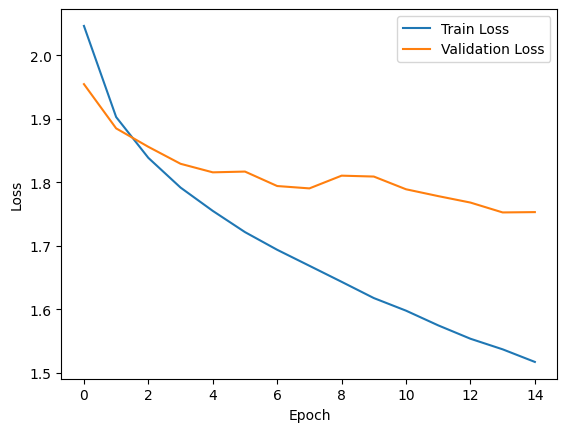

In [67]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

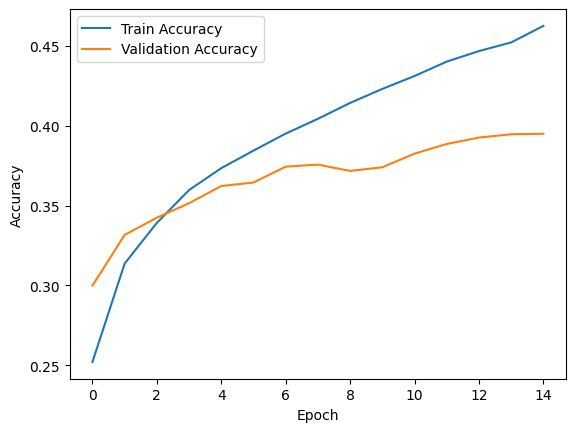

In [68]:
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluating the test data

In [75]:
def eval_model(model, data, class_labels):
    model.eval()
    all_labels=[]
    preds=[]

    with torch.no_grad():
        for imgs, labels in data:
            imgs= imgs.to(device)
            labels=labels.to(device)
            out=model(imgs)
            _, pred= torch.max(out,1)

            all_labels.extend(labels.cpu().numpy())
            preds.extend(pred.cpu().numpy())

    print('Classification Report:')
    print(classification_report(all_labels,preds, target_names=class_labels))

    print('Confusion Matrix:')
    cm=confusion_matrix(all_labels,preds)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()
    plt.tight_layout()
    disp.ax_.set_xticklabels(labels= class_labels, rotation=90)
    plt.show()



Classification Report:
              precision    recall  f1-score   support

       plane       0.42      0.41      0.41      1000
         car       0.48      0.45      0.46      1000
        bird       0.33      0.27      0.30      1000
         cat       0.28      0.26      0.27      1000
        deer       0.36      0.27      0.31      1000
         dog       0.40      0.30      0.35      1000
        frog       0.35      0.51      0.42      1000
       horse       0.48      0.41      0.44      1000
        ship       0.39      0.56      0.46      1000
       truck       0.44      0.48      0.46      1000

    accuracy                           0.39     10000
   macro avg       0.39      0.39      0.39     10000
weighted avg       0.39      0.39      0.39     10000

Confusion Matrix:


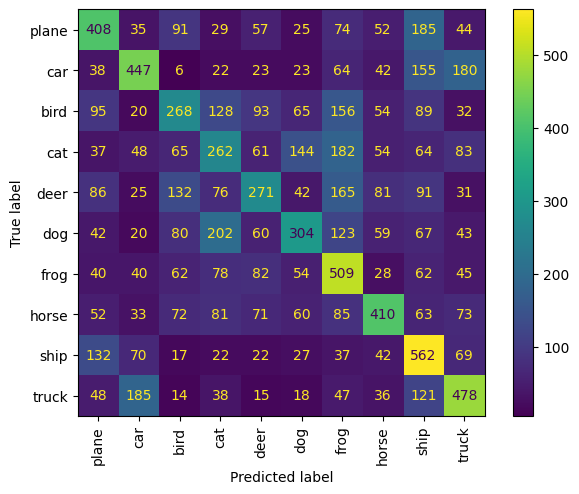

In [76]:
labels= ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
eval_model(model, test_loader, labels)

# Answers

In [77]:
import torchsummary

In [79]:
torchsummary.summary(model, input_size=(1,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         262,400
            Linear-2               [-1, 1, 256]          65,792
            Linear-3                [-1, 1, 10]           2,570
Total params: 330,762
Trainable params: 330,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.26
Estimated Total Size (MB): 1.27
----------------------------------------------------------------


Number of Hidden Layers: 2

Neurons/Layer: 1024, 256,256, 10

Activation: ReLU